In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

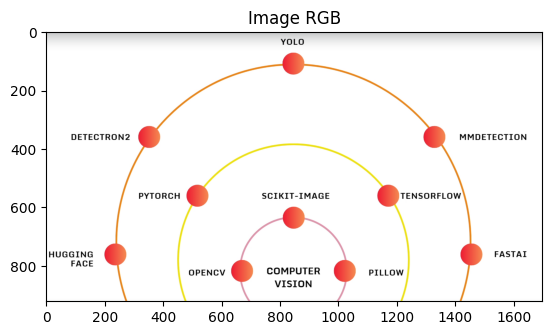

In [2]:
image=cv2.imread("./Images/Connection between Scikit Image, Open CV, Pillow, TF,Torch, YOLO.png")
image_rgb=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title("Image RGB")
plt.show()

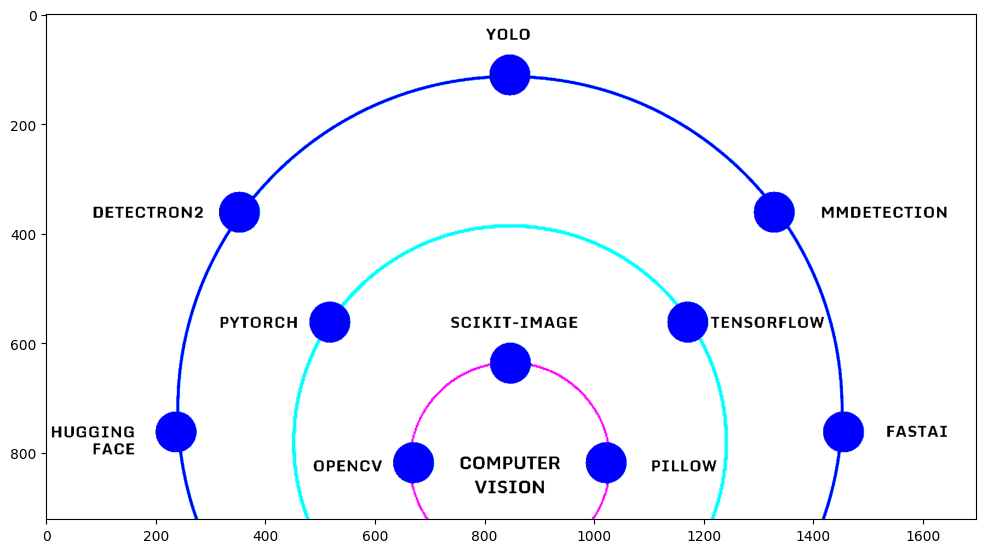

In [3]:
val,binary=cv2.threshold(image,150,255,cv2.THRESH_BINARY)
plt.figure(figsize=(12,7))
plt.imshow(binary,cmap="grey")
plt.show()

### Adaptive thresholding

In [4]:
image_gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

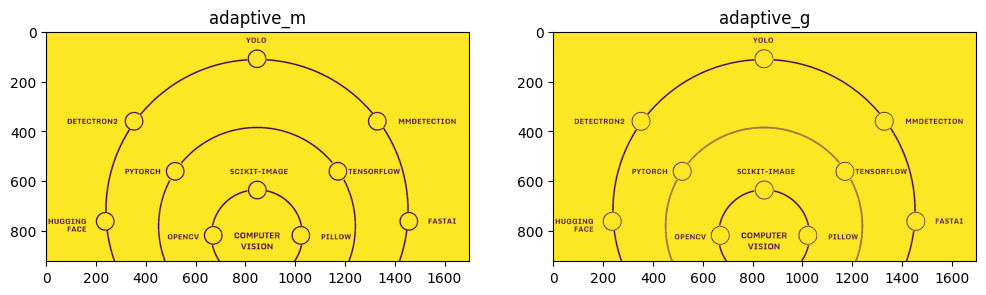

In [5]:
adaptive_m=cv2.adaptiveThreshold(image_gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,9)
adaptive_g=cv2.adaptiveThreshold(image_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,9)
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.imshow(adaptive_m)
plt.title("adaptive_m")
plt.subplot(1,2,2)
plt.imshow(adaptive_g)
plt.title("adaptive_g")
plt.show()

### kmeans clustering

In [6]:
pixel_values=image_rgb.reshape((-1,3))

In [7]:
pixel_values=np.float32(pixel_values)

In [8]:
print(pixel_values)

[[190. 191. 192.]
 [190. 191. 193.]
 [190. 191. 192.]
 ...
 [247. 247. 247.]
 [247. 247. 247.]
 [247. 247. 247.]]


In [9]:
criteria=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,100,0.2)
k=3
_,labels,centers=cv2.kmeans(pixel_values,k,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

In [10]:
print(labels.shape)
print(centers)

(1565556, 1)
[[231.83797   114.15029    66.52493  ]
 [  9.710091    9.718955    9.7342615]
 [253.85637   253.79756   253.61015  ]]


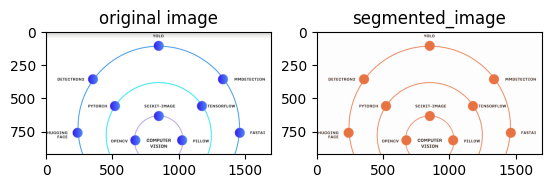

In [11]:
centers=np.uint8(centers)
segmented_image=centers[labels.flatten()]
segmented_image=segmented_image.reshape(image.shape)

plt.Figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("original image")

plt.subplot(1,2,2)
plt.imshow(segmented_image)
plt.title("segmented_image")

plt.show()

### watershed algorithm

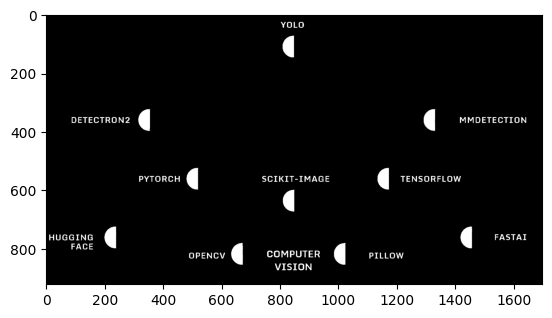

In [12]:
grey=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
_,thresh=cv2.threshold(grey,130,255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh,cmap="grey")

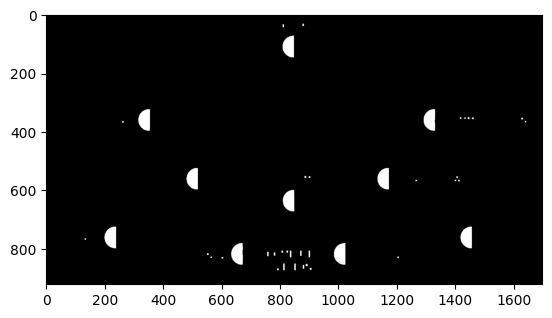

In [13]:
kernel=np.ones((3,3),np.uint8)
opening=cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)
plt.imshow(opening,cmap="grey")
plt.show()

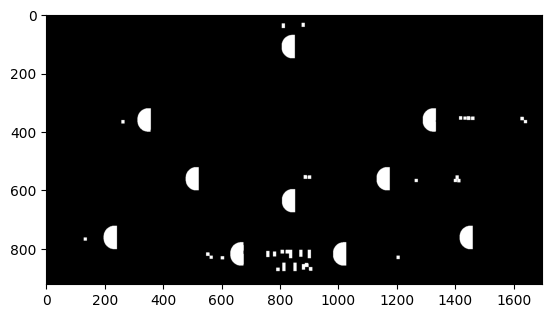

In [14]:
sure_bg=cv2.dilate(opening,kernel,iterations=3)
plt.imshow(sure_bg,cmap="grey")

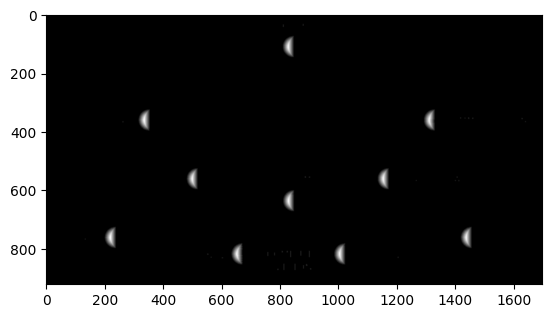

In [15]:
dist_transform=cv2.distanceTransform(opening,cv2.DIST_L2,5)
plt.imshow(dist_transform,cmap="grey")
plt.show()

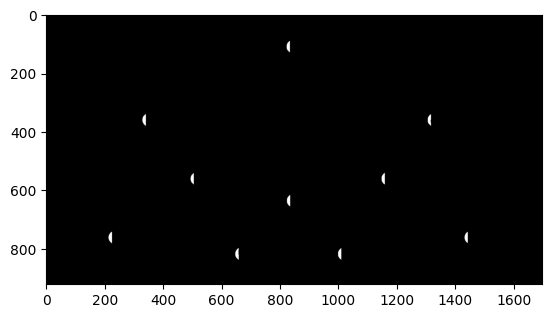

In [16]:
_,sure_fg=cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
sure_fg=np.uint8(sure_fg)
plt.imshow(sure_fg,cmap="grey")
plt.show()

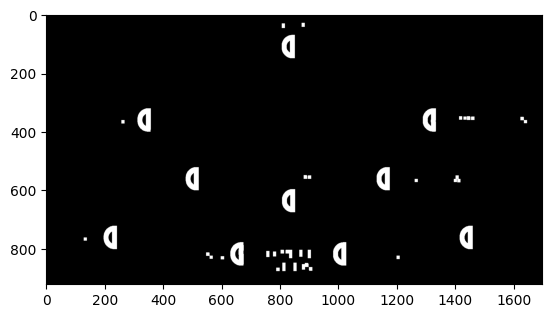

In [17]:
unknown=cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown,cmap="grey")

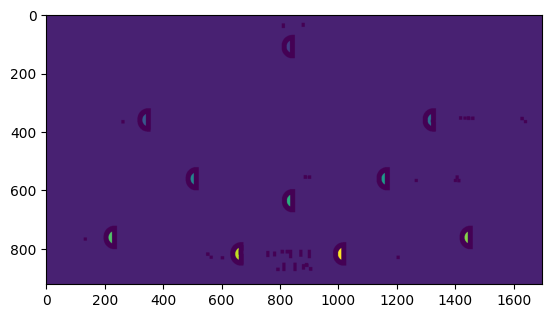

In [18]:
_,markers=cv2.connectedComponents(sure_fg)
markers=markers+1
markers[unknown==255]=0

plt.imshow(markers)
plt.show()

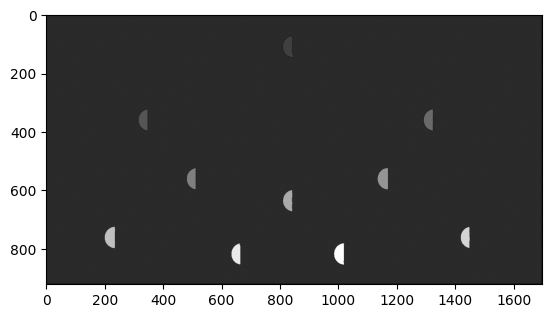

In [19]:
markers=cv2.watershed(image,markers)
plt.imshow(markers,cmap="grey")
plt.show()

In [21]:
coin_mask=np.zeros_like(grey)
print(grey.shape)
print(coin_mask.shape)

unique_labels=np.unique(markers)
original_image=cv2.imread("./Images/Connection between Scikit Image, Open CV, Pillow, TF,Torch, YOLO.png")
instance_number=1
font=cv2.FONT_HERSHEY_SIMPLEX
for label in unique_labels:
    if label==0 or label==-1:
        continue
    
    mask=np.uint8(markers==label)
    contours,_=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area=cv2.contourArea(contour)
        perimeter=cv2.arcLength(contour,True)
        if perimeter==0:
            continue
        circularity=4*np.pi * (area/(perimeter**2)) 
        if circularity>0.7 and circularity<1.2 and area>1000:
            cv2.drawContours(original_image,[contour],-1,(0,255,0),-2)
            x,y,w,h=cv2.boundingRect(contour)
            cv2.putText(original_image,f"instance_numbe: {instance_number}",(x,y-10),font,0.6,(255,255,0),2)
            coin_mask=cv2.bitwise_or(coin_mask,mask)
            cv2.rectangle(original_image,(x-5,y-5),(x+w+5,y+h+5),(160,150,250),2)

(922, 1698)
(922, 1698)


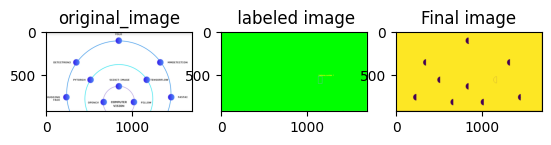

In [23]:
plt.Figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(image)
plt.title("original_image")

plt.subplot(1,3,2)
plt.imshow(original_image)
plt.title(" labeled image")

plt.subplot(1,3,3)
plt.imshow(coin_mask)
plt.title("Final image")
plt.show()